<a href="https://colab.research.google.com/github/lnemzer/Python/blob/master/AutoTHINKERmatrix.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#THINKER 2.0
###"Theoretical Hodgkin-Huxley Ion-Gated Network Connectome Electroencephalographic Replicator"
###Louis R. Nemzer, Ph.D.
####Feb 2020

In [0]:
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import random
import tabulate as tab
import tqdm

#Synapse Transfer Function
cen=0
width=10
synmax=40
def Trans2(z):
  if np.all(z<=-40):
    return 0
  else:
    return synmax*2/(1+np.exp(-(z-cen)/width)+1)-1.5
#Gate/Voltage Increments
def mdot(m,v):
  return am(v)*(1-m)-bm(v)*m
def hdot(h,v):
  return ah(v)*(1-h)-bh(v)*h 
def ndot(n,v):
  return an(v)*(1-n)-bn(v)*n
def vdot(m,h,n,v):
  return (-gnmax*(m**3)*h*(v-vna))-(gkmax*(n**4)*(v-vk))-(gleak*(v-vleak))

In [46]:
matrix=[]
for Gmax in np.linspace(2.5,2.5,num=1):
  for sticky in np.linspace(2.0,2.0,num=1):
    matrix.append((np.around(Gmax,2),np.around(sticky,2)))
    #matrix.append((np.around(Gmax,2),np.around(sticky,2)))
    #matrix.append((np.around(Gmax,2),np.around(sticky,2)))
colnames=[]
for para in matrix:
  colnames.append(str(para))
print(colnames)

['(2.5, 2.0)']


In [47]:
len(colnames)

1

In [48]:
alleeg=[]
allhist=[]
#CONSTANTS

dt = 0.05 # 
runFor = 200 # Runtime in ms

gnmax = 120   #maximum Na+ conductivity
gkmax = 36    #maximum K+ conductivity
gleak = 0.3   #maximum leak conductivity
iinj = 0      #inital injection current
vna = 50      #Na+ reversal voltage
vk = -77      #K+ reversal voltage 
vleak = -54   #Leak reversal voltage
c = 1         #Normalized membrane capacitance

for para in tqdm.tqdm(matrix):

  #Gate Stickyness
  CPm,CPn,CPh =1,1,para[1]
  gmin = 0 #Minimum coupling of neurons (negative is inhibitory)
  gmax = para[0] #Maximum coupling of neurons

  #Connectivity Matrix
  nn=(2**5)+1 #number of nodes
  G=nx.watts_strogatz_graph(nn,6,0.3)
  #nx.draw_circular(G, with_labels=True, font_weight='bold')
  edgelist=np.array(G.edges)
  #print(G.edges)
  newedges=[]
  for edge in edgelist:
    if random.random()>0.5:
      newedges=np.append(newedges,edge)
    else:
      newedges=np.append(newedges,np.flip(edge))
  l=int(len(newedges))
  newedges2=newedges.reshape(int(l/2),2)
  G2 = nx.DiGraph()
  for edge in newedges2:
    G2.add_edge(edge[0],edge[1])
  #nx.draw_circular(G2)
  wam=np.asarray(nx.to_numpy_matrix(G2))
  g=np.multiply(wam,np.random.rand(nn,nn))*gmax

  #Voltage dependent ion-gate opening and closing rates
  def am(v):
    return np.nan_to_num(CPm*0.1*(v + 40)/(1 - np.exp(-(v + 40)/10)))
  def bm(v):
    return CPm*4*np.exp(-(v + 65)/18)
  def an(v):
    return np.nan_to_num(CPn*0.01*(v + 55)/(1-np.exp(-(v + 55)/10)))
  def bn(v):
    return CPn*0.125*np.exp(-(v + 65)/80)
  def ah(v):
    return CPh*0.07*np.exp(-(v + 65)/20)
  def bh(v):
    return CPh*1/(1+np.exp(-(v + 35)/10))

  #INITIALIZE VARIABLES
  v0 = -64.0
  #MAIN LOOP
  #SETTING INTIAL GATES TO THEIR STEADY-STATE
  mSS = am(v0)/(am(v0) + bm(v0))
  nSS = an(v0)/(an(v0) + bn(v0)) 
  hSS = ah(v0)/(ah(v0) + bh(v0)) 

  v = np.full(nn,v0)
  m=np.full(nn,mSS)
  n=np.full(nn,nSS)
  h=np.full(nn,hSS)

  patchlow = 10
  patch = 20

  aVt=[]
  time=0
  maxsteps=int(runFor/dt)
  for time in range(maxsteps):
    v[0]=patch*np.random.normal(0, 0.25, size=1)+patchlow
    transfer = np.array(np.dot(np.array(list(map(Trans2,v))),g))
    for i in range (1,nn):
      m[i] = np.clip(m[i]+mdot(m[i],v[i])*dt,0,1)
      h[i] = np.clip(h[i]+hdot(h[i],v[i])*dt,0,1)
      n[i] = np.clip(n[i]+ndot(n[i],v[i])*dt,0,1)
      v[i] = v[i]+(vdot(m[i],h[i],n[i],v[i])+transfer[i])*dt
    aVt = np.append(aVt, v)
    time+=dt
  volts=aVt.reshape(int(len(aVt)/nn),nn).transpose()
  df=pd.DataFrame(volts)
  df3=df.drop([0])
  df.loc['mean'] = df.mean()
  eeg=df.tail(1).values[0]
  alleeg.append((eeg))
  sim=df3[df3 > 10].count() 
  hist=np.histogram(np.asarray(sim), bins=[0, 1, 2, 3,4,5,6,7,8,9,10,11,12,13,14,15,16])
  allhist.append(hist[0])
  #df_hist=pd.DataFrame(hist[0])
  #(df_hist.T).to_excel("hist_"+str(para[0])+"_"+str(para[1])+".xlsx")
df_eeg=pd.DataFrame(alleeg)
df_eeg2=df_eeg.T
df_eeg2.columns=colnames
df_eeg2.to_excel("alleeg.xlsx")

df_hist=pd.DataFrame(allhist)
df_hist2=df_hist.T
df_hist2.columns=colnames
df_hist2.to_excel("allhist.xlsx")

100%|██████████| 1/1 [00:24<00:00, 24.33s/it]


In [0]:
df_T=df.T
dfTarray=df_T.values
import os
os.chdir("/content")
df_T.to_excel("df_T.xlsx")

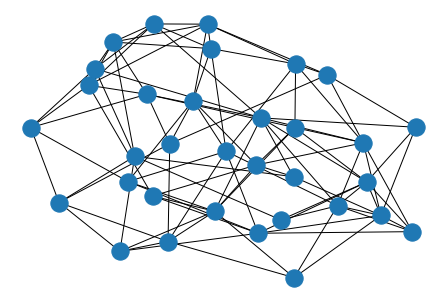

In [50]:
nx.draw(G)
pos1 = nx.spring_layout(G)

In [0]:
os.getcwd()
try: 
  os.mkdir("/content/pics0")
except:
  pass
os.chdir("/content/pics0")

In [56]:
os.getcwd()

'/content/pics0'

In [54]:
filenames=[]
for i in tqdm.tqdm(np.arange(0,len(df_T),10)):
  threshold = 0
  compare=np.full(len(dfTarray[1]),threshold)

  #data=np.greater(dfTarray[i],compare)*1
  data=dfTarray[i]
  nx.draw(G,pos=pos1, with_labels=False, node_color=data[:-1], cmap=plt.cm.Reds,node_size=100)
  filename=str("graph"+str(i).zfill(3)+".png")
  filenames.append(filename)
  plt.savefig(filename)
  plt.close()

100%|██████████| 400/400 [00:43<00:00,  9.21it/s]


In [0]:
import PIL
from PIL import Image

In [0]:
images = []

for n in filenames[:-1]:
    frame = Image.open(n)
    images.append(frame)

# Save the frames as an animated GIF
images[0].save('/content/amovie0.gif',
               save_all=True,
               append_images=images[1:],
               duration=100,
               loop=0)

In [0]:
import cv2
import os

image_folder = 'images'
video_name = 'video.avi'

images = [img for img in os.listdir(image_folder) if img.endswith(".png")]
frame = cv2.imread(os.path.join(image_folder, images[0]))
height, width, layers = frame.shape

video = cv2.VideoWriter(video_name, 0, 1, (width,height))

for image in images:
    video.write(cv2.imread(os.path.join(image_folder, image)))

cv2.destroyAllWindows()
video.release()

In [0]:
volty=(df).values

In [13]:
df.T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,mean
0,2.529915,-62.824937,-63.104146,-64.057246,-62.845691,-64.057246,-63.103524,-64.057246,-64.057246,-64.057246,-64.057246,-64.057246,-64.057246,-64.057246,-64.057246,-64.057246,-64.057246,-64.057246,-64.057246,-64.057246,-64.057246,-64.057246,-64.057246,-64.057246,-64.057246,-64.057246,-64.057246,-64.057246,-64.057246,-64.057246,-64.057246,-64.057246,-64.057246,-61.907614
1,11.952383,-61.420760,-62.030680,-64.112616,-61.466096,-64.112616,-62.029320,-64.112616,-64.112616,-64.112616,-64.112616,-64.112616,-64.112616,-64.112616,-64.112616,-64.112616,-64.112616,-64.112616,-64.112616,-64.112616,-64.112616,-64.112616,-64.112616,-64.112616,-64.112616,-64.112616,-64.112616,-64.112616,-64.112616,-64.112616,-64.112616,-64.112616,-64.112616,-61.519628
2,9.663779,-60.108099,-61.027841,-64.166401,-60.176469,-64.166401,-61.025791,-64.166401,-64.166401,-64.166401,-64.166401,-64.166401,-64.166401,-64.166401,-64.166401,-64.166401,-64.166401,-64.166401,-64.166401,-64.166401,-64.166401,-64.166401,-64.166401,-64.166401,-64.166401,-64.166401,-64.166401,-64.166401,-64.166401,-64.166401,-64.166401,-64.166401,-64.166401,-61.494959
3,13.009143,-58.753155,-59.992782,-64.218814,-58.845324,-64.218814,-59.990019,-64.218814,-64.218814,-64.218814,-64.218814,-64.218814,-64.218814,-64.218814,-64.218814,-64.218814,-64.218814,-64.218814,-64.218814,-64.218814,-64.218814,-64.218814,-64.218814,-64.218814,-64.218814,-64.218814,-64.218814,-64.218814,-64.218814,-64.218814,-64.218814,-64.218814,-64.218814,-61.293907
4,12.568126,-57.429425,-58.983588,-64.270018,-57.545044,-64.270018,-58.980126,-64.270018,-64.270018,-64.270018,-64.270018,-64.270018,-64.270018,-64.270018,-64.270018,-64.270018,-64.270018,-64.270018,-64.270018,-64.270018,-64.270018,-64.270018,-64.270018,-64.270018,-64.270018,-64.270018,-64.270018,-64.270018,-64.270018,-64.270018,-64.270018,-64.270018,-64.270018,-61.210017
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3995,5.884745,-52.267026,13.008893,-64.452109,-36.986063,-50.947209,-50.546295,-71.320077,-67.788602,-71.338831,-71.948231,-72.062614,-67.667996,-71.620786,-66.860941,-73.538869,-67.332349,-69.396456,-70.317303,-64.683602,-65.817337,-72.123936,-71.272196,-72.786311,-71.552743,-71.323021,-71.782445,-70.253557,-72.906157,-73.352709,-74.342482,-71.824670,-64.897673,-62.618696
3996,6.423048,-51.938667,10.424106,-63.485246,-34.262060,-47.916075,-49.366388,-71.261050,-67.740062,-71.247600,-71.889827,-72.004432,-67.089413,-71.542655,-66.823646,-73.486860,-67.287995,-69.340443,-70.258949,-64.676181,-65.793619,-72.065896,-71.213105,-72.730361,-71.493795,-71.263945,-71.723771,-70.195307,-72.850713,-73.299555,-74.288616,-71.766067,-64.897673,-62.374328
3997,15.257657,-51.372514,7.290271,-62.592508,-30.747276,-44.864345,-47.994918,-71.202007,-67.691808,-71.111518,-71.831322,-71.946130,-66.558545,-71.437680,-66.786534,-73.434520,-67.243910,-69.284619,-70.200698,-64.669005,-65.770044,-72.007729,-71.154003,-72.674187,-71.434799,-71.204852,-71.665018,-70.137166,-72.795028,-73.246096,-74.223364,-71.707378,-64.897673,-61.858766
3998,6.846127,-50.966979,3.465336,-61.787843,-26.734546,-41.668954,-46.718482,-71.142956,-67.643841,-70.900422,-71.772722,-71.887719,-66.084206,-71.287876,-66.749610,-73.381856,-67.200094,-69.228989,-70.142556,-64.662073,-65.746619,-71.949443,-71.094899,-72.617798,-71.375763,-71.145750,-71.606195,-70.079142,-72.739110,-73.192338,-74.139619,-71.648613,-64.897673,-61.875249


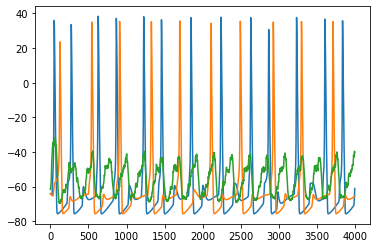

In [58]:
plt.plot(volty[3])
plt.plot(volty[20])
plt.plot(alleeg[0])

In [15]:
sig=volty[10]
#sig=alleeg[0]
freqs, psd = signal.welch(sig)
plt.figure(figsize=(5, 4))
plt.semilogx(freqs, psd)
plt.title('PSD: power spectral density')
plt.xlabel('Frequency')
plt.ylabel('Power')
plt.tight_layout()

NameError: ignored

In [0]:
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

In [17]:
ydata=df_hist2.iloc[:, [1]].T.values[0]
def func(x, a, b):
  return a * (x**b)
xdata = range(0,16)
plt.plot(xdata,ydata, 'b-', label='data',marker='s')
popt, pcov = curve_fit(func, xdata[2:9], ydata[2:9])

plt.plot(xdata, func(xdata, *popt), 'r-',
         label='fit: a=%5.3f, b=%5.3f' % tuple(popt))
plt.ylabel('Counts')
plt.xlabel('Simultaneous Neurons')
plt.legend()
plt.ylim(0,2000)
plt.xlim(1,10)

plt.show()

IndexError: ignored

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in power
  """


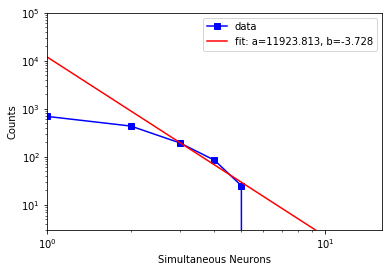

In [0]:
plt.plot(xdata,ydata, 'b-', label='data',marker='s')
popt, pcov = curve_fit(func, xdata[3:-2], ydata[3:-2])

plt.plot(xdata, func(xdata, *popt), 'r-',
         label='fit: a=%5.3f, b=%5.3f' % tuple(popt))
plt.ylim(3,100000)
plt.xlim(1,16)
plt.ylabel('Counts')
plt.xlabel('Simultaneous Neurons')
plt.xscale("log")
plt.yscale("log")

plt.legend()
plt.show()

In [0]:
import pywt
import matplotlib.colors as colors

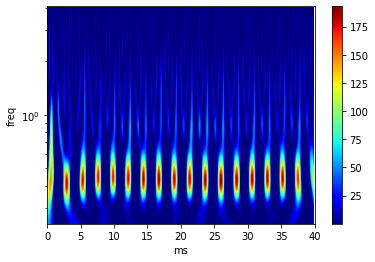

In [83]:
#i=3
#sig0=df_eeg2.iloc[:, [1]].T.values[0]
#sig0 = df_input[df_input.columns[i]].values
sig0 = df_eeg2.T.values[0]
sig = sig0-sig0.mean()
def sample(x): 
    return 1/(x*dt)
maxpoints=len(sig)
widths=list(map(sample, np.arange(5.0,0.3,-0.001)))
cwtmatr,freq = pywt.cwt(sig, widths, 'morl', dt)

im=plt.imshow(cwtmatr, extent=[0, int(maxpoints*dt), freq[-1], freq[0]], cmap='jet', aspect='auto',
            vmax=abs(cwtmatr).max(), vmin=abs(cwtmatr).min())
plt.colorbar(mappable=None, cax=None, ax=None)
plt.yscale('log')
plt.ylabel('freq')
plt.xlabel('ms')
plt.savefig("ascalogram"+str(i)+".jpg")
plt.show()

In [67]:
dt = 0.01  # 100 Hz sampling
frequencies = pywt.scale2frequency('cmor1.5-1.0', [1, 2, 3, 4]) / dt
frequencies

array([100.        ,  50.        ,  33.33333333,  25.        ])

In [0]:
pd.DataFrame(freq).to_excel("freq.xlsx")

In [0]:
pd.DataFrame(cwtmatr).to_excel("cwtmatr.xlsx")

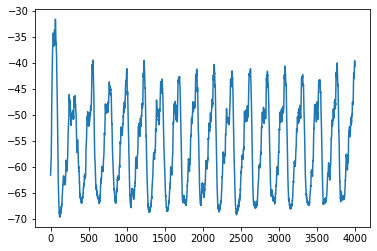

In [62]:
plt.plot(sig0)

In [0]:
fits=[]
for i in range(len(colnames)):
  ydata0=ydata=df_hist2.iloc[:, [i]].T.values[0]
  start0=2
  end0=8

  def pow(x, a, b):
    return a * (x**b)
  def exp0(x, c, d):
    return c*np.exp(x*d)
  xdata = range(start0,end0)
  ydata = ydata0[start0:end0]
  print(ydata)
  try:
    pop_pow, cov_pow = curve_fit(pow, xdata, ydata)
    pop_exp, cov_exp = curve_fit(exp0, xdata, ydata)

    perr_pow = np.sqrt(np.diag(cov_pow))
    perr_exp = np.sqrt(np.diag(cov_exp))

    #plt.plot(xdata,ydata, 'b-', label='data',marker='s')
    #plt.plot(xdata, pow(xdata, *pop_pow), 'r-',
    #        label='fit: a=%5.3f, b=%5.3f' % tuple(pop_pow))
    #plt.plot(xdata, exp0(xdata, *pop_exp), 'g-',
    #        label='fit: c=%5.3f, d=%5.3f' % tuple(pop_exp))
    #plt.ylim(10,1000)
    #plt.xlim(1,10)
    #plt.ylabel('Counts')
    #plt.xlabel('Simultaneous Neurons')
    ##plt.xscale("log")
    #plt.yscale("log")
    #plt.legend()
    #plt.show()

    fits=np.append(fits,[matrix[i][0],matrix[i][1],pop_pow[0],perr_pow[0],pop_pow[1],perr_pow[1],pop_exp[0],perr_exp[0],pop_exp[1],perr_exp[1]])
  except:
    continue

[0 0 0 0 0 0]
[0 0 0 0 0 0]
[0 0 0 0 0 0]
[0 0 0 0 0 0]
[0 0 0 0 0 0]
[0 0 0 0 0 0]
[0 0 0 0 0 0]
[0 0 0 0 0 0]
[0 0 0 0 0 0]
[0 0 0 0 0 0]
[0 0 0 0 0 0]
[0 0 0 0 0 0]
[0 0 0 0 0 0]
[0 0 0 0 0 0]
[0 0 0 0 0 0]
[810 562 165  49  40   1]
[14  0  0  0  0  0]
[39  0  0  0  0  0]
[43  6  0  0  0  0]
[164   4   0   0   0   0]
[161  25   0   0   0   0]
[0 0 0 0 0 0]
[0 0 0 0 0 0]
[0 0 0 0 0 0]
[0 0 0 0 0 0]
[0 0 0 0 0 0]
[0 0 0 0 0 0]
[411 269 178 201 186 193]
[684 495 276  78  15   0]
[366 331 299 211  75  61]
[883 359  67  13   0   0]
[577 231  70  16   4   0]
[302 238 152  51  14   2]
[300  46   3   0   0   0]
[7 0 0 0 0 0]
[0 0 0 0 0 0]
[0 0 0 0 0 0]
[0 0 0 0 0 0]
[0 0 0 0 0 0]
[700 510 283 183  90  71]
[354 585 301 264 225 174]
[237 126 168 115  85  84]
[383 327 207 121  38  28]
[904 495 171  28   2   3]
[59 24 13 12  2  0]
[246  77  15   2   0   0]
[267  93  36   2   0   0]
[29 17  5  2  0  0]
[0 0 0 0 0 0]
[0 0 0 0 0 0]
[0 0 0 0 0 0]
[618 408 360 277 139  86]
[828 535 393 194  91  38]


In [0]:
df_fits=pd.DataFrame(fits.reshape(int(len(fits)/10),10))

In [0]:
df_fits.to_excel("fit3.xlsx")